In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
df = pd.read_csv("../dataset/BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv")

array([<AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Timestamp'>,
       <AxesSubplot: xlabel='Times

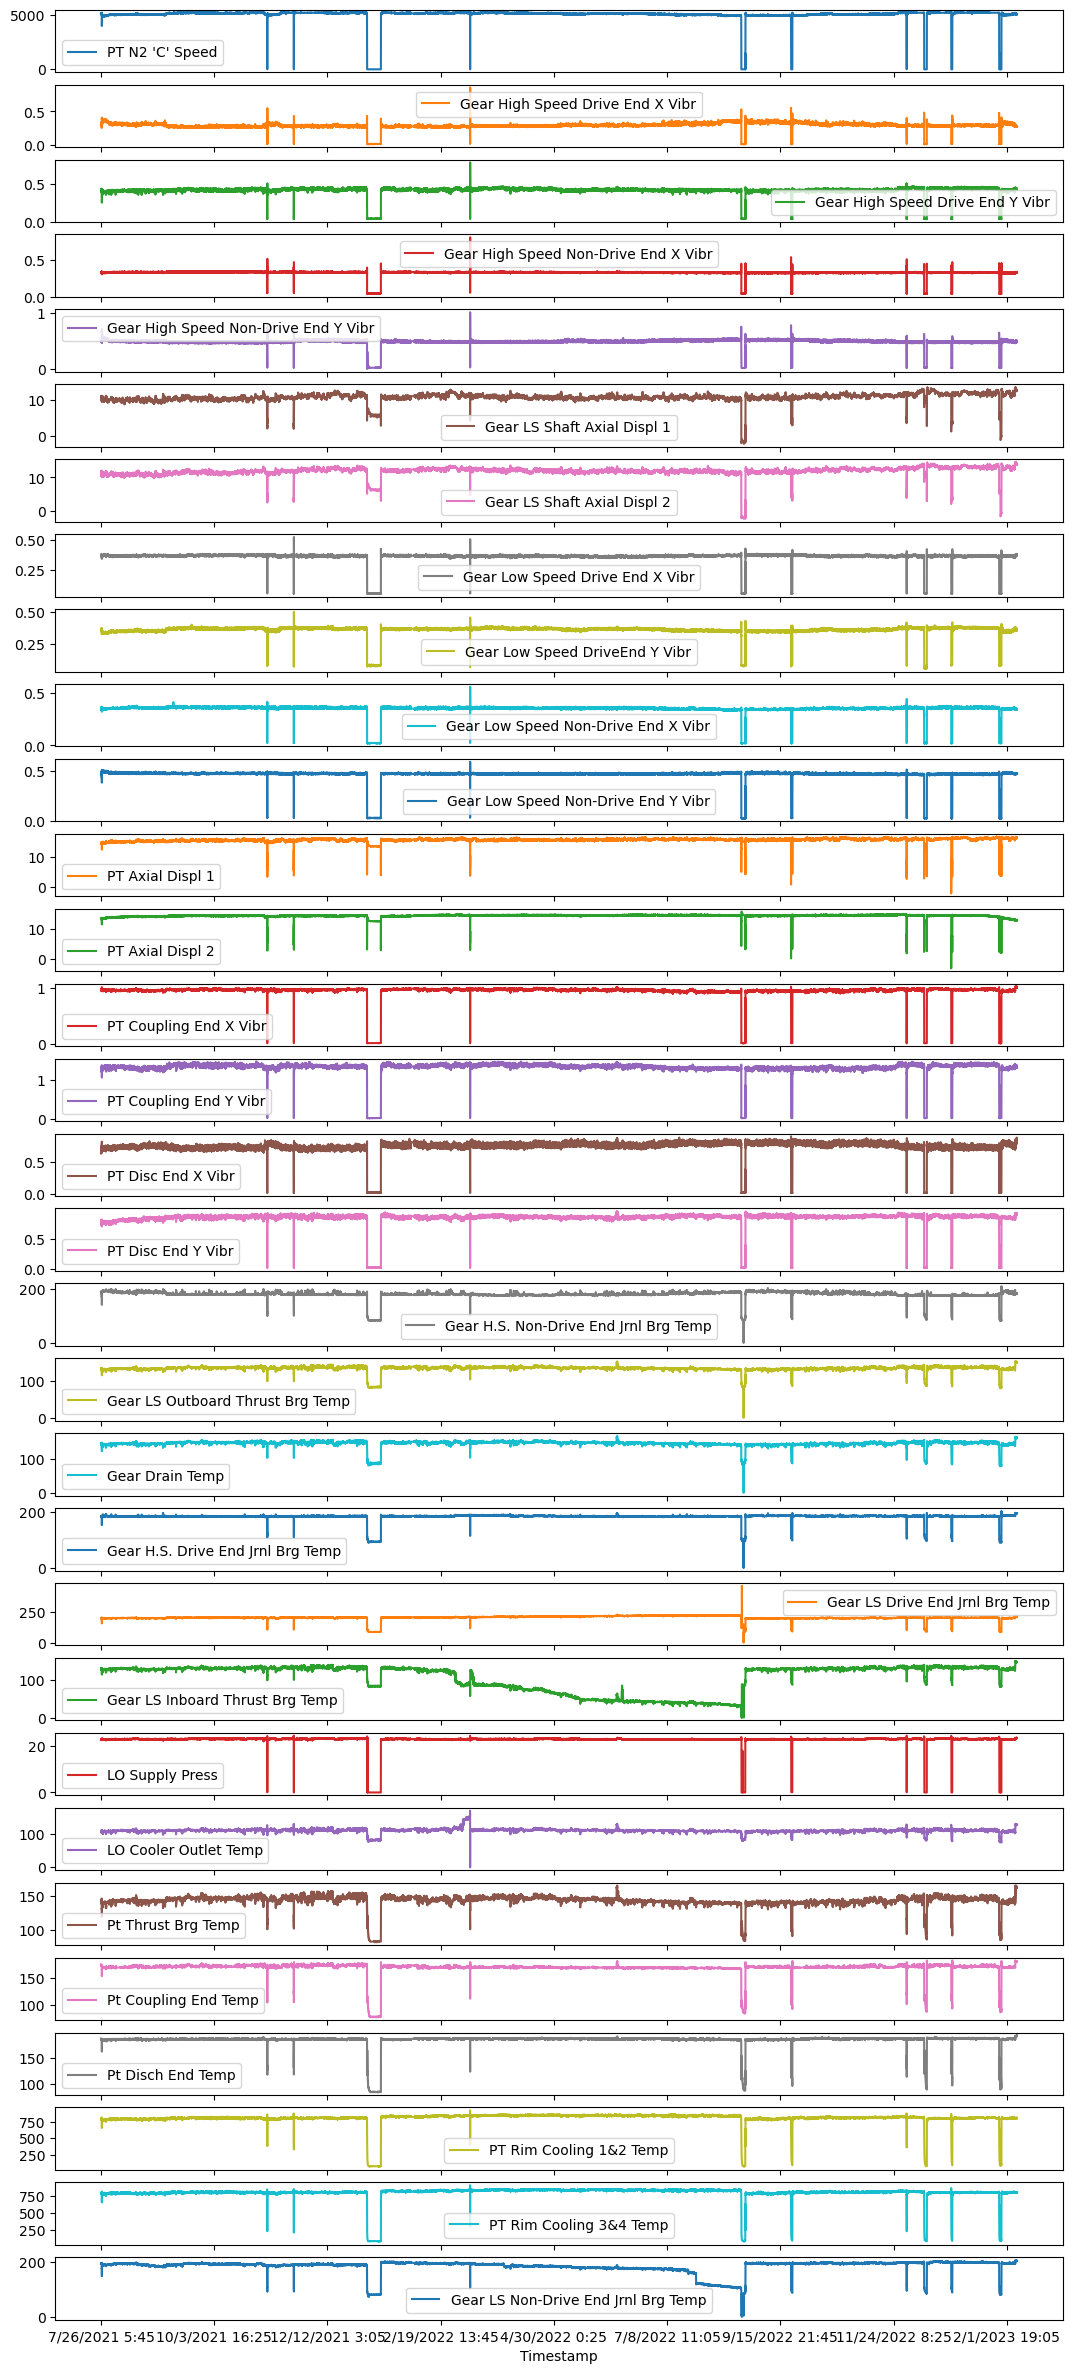

In [3]:
df.plot(x="Timestamp", subplots=True, figsize=(13,30))

In [5]:
df.shape
# if 'Gear LS Inboard Thrust Brg Temp' in df.columns:
#     df.drop('Gear LS Inboard Thrust Brg Temp', axis=1, inplace=True)

(161788, 32)

In [6]:
df_sample = df.loc[:60000-1]
df_sample.to_csv("../dataset/data_sample.csv", index=False)

In [7]:
df_sample_test = df.loc[60000:80000-1]
df_sample_test.to_csv("../dataset/data_sample_test.csv", index=False)

# ==========================================

In [8]:
df_sample = pd.read_csv("../dataset/data_sample.csv", index_col="Timestamp")
print(df_sample.shape)

(60000, 31)


In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# scaler = MinMaxScaler([0,1])
scaler = StandardScaler()
df_sample_scaled = scaler.fit_transform(df_sample)
pickle.dump(scaler, open('StandardScaler.pkl', 'wb'))

[]

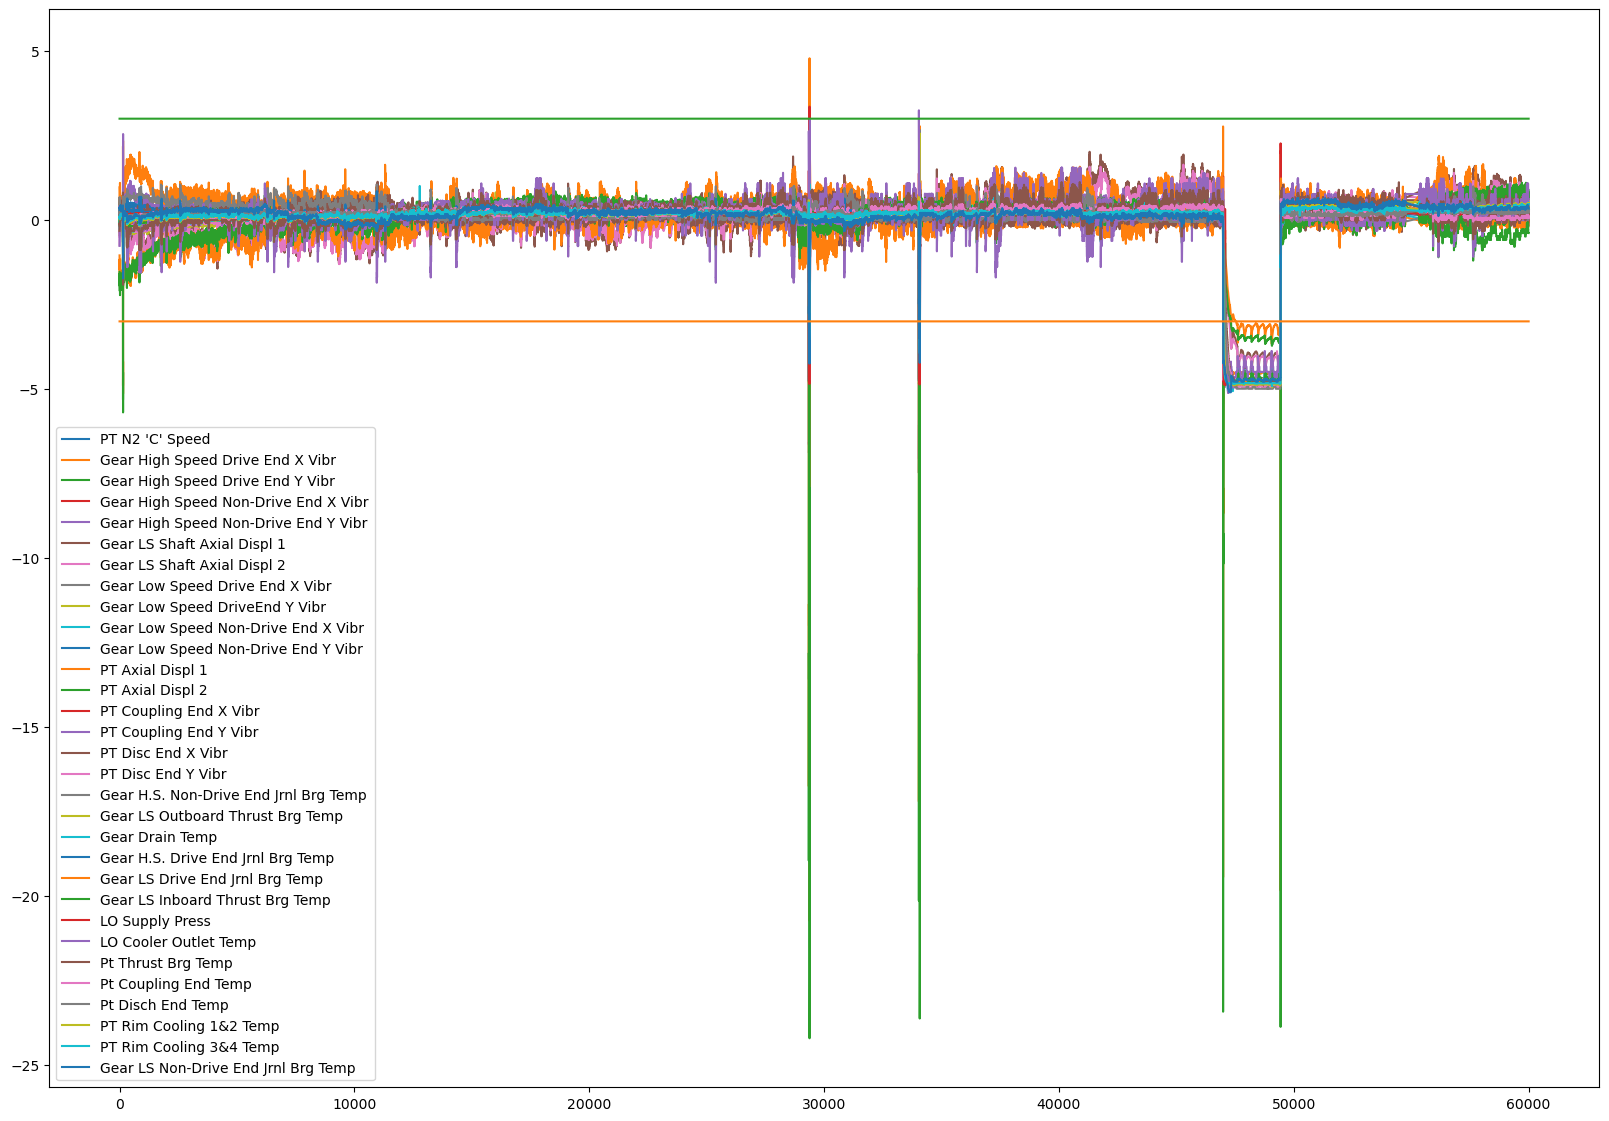

In [11]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.plot(np.full(df_sample_scaled.shape[0], -3))
plt.plot(np.full(df_sample_scaled.shape[0], 3))
plt.legend(df_sample.columns)
plt.plot()

In [12]:
df_sample_label = np.where(np.any((df_sample_scaled < -3) | (df_sample_scaled > 3), axis=1), 1, 0)

In [15]:
# from sklearn.neighbors import LocalOutlierFactor
# lof = LocalOutlierFactor()

# yyy = lof.fit_predict(df_sample_scaled)

[]

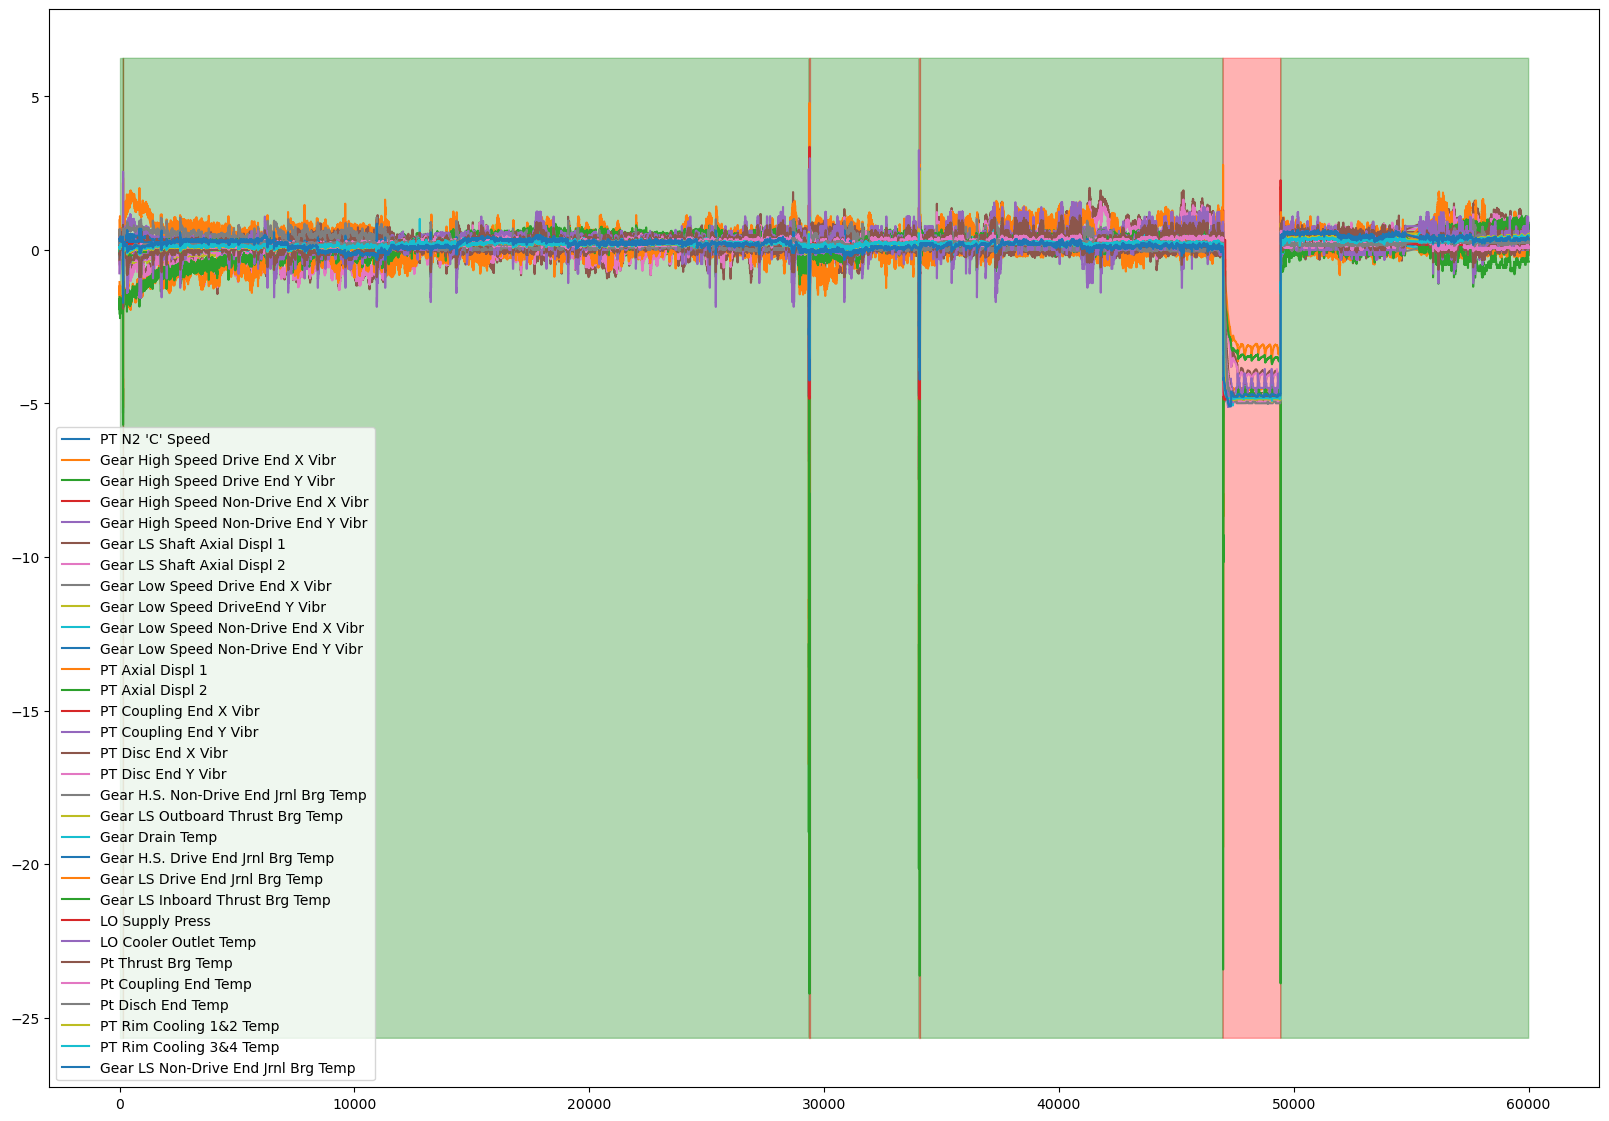

In [13]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample_label == 1), color='red', alpha=0.3)
plt.legend(df_sample.columns)
plt.plot()

In [14]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [15]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [16]:
df_sample_scaled_3d = convert_time_window(df_sample_scaled, 10)

In [17]:
def create_lstm_autoencoder(timesteps, n_features):
    input_layer = keras.layers.Input(shape=(timesteps, n_features))
    encoder = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
    encoder = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoder)

    decoder = keras.layers.RepeatVector(timesteps)(encoder)
    decoder = keras.layers.LSTM(32, activation='relu', return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoder)
    output_layer = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="LSTM-Autoencoder")
    return model

In [18]:
lstm_model = create_lstm_autoencoder(10, df_sample_scaled.shape[1])
lstm_model.summary()

Model: "LSTM-Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            24576     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                  

In [19]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    mode='min')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', mode='min', verbose=1, save_best_only=True)
    return [tensorboard_callback, early_stopping, mc]

In [20]:
lstm_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['acc'])

In [21]:
history = lstm_model.fit(df_sample_scaled_3d, df_sample_scaled_3d, callbacks=myCallbacks('../logs/train/2'), epochs=100, batch_size=32)

Epoch 1/100
1873/1875 [============================>.] - ETA: 0s - loss: 0.1675 - acc: 0.3771
Epoch 1: loss improved from inf to 0.16736, saving model to ../logs/train/2\best_model.h5
1875/1875 [==============================] - 45s 21ms/step - loss: 0.1674 - acc: 0.3773
Epoch 2/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0247 - acc: 0.6743
Epoch 2: loss improved from 0.16736 to 0.02469, saving model to ../logs/train/2\best_model.h5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0247 - acc: 0.6743
Epoch 3/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0173 - acc: 0.7095
Epoch 3: loss improved from 0.02469 to 0.01741, saving model to ../logs/train/2\best_model.h5
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0174 - acc: 0.7094
Epoch 4/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0136 - acc: 0.7274
Epoch 4: loss improved from 0.01741 to 0.01359, saving model to ../logs/train/2\be

## ===============================================

In [7]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

In [8]:
df_sample_test = pd.read_csv("../dataset/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [10]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -5) | (df_sample_test_scaled > 5), axis=1), 1, 0)

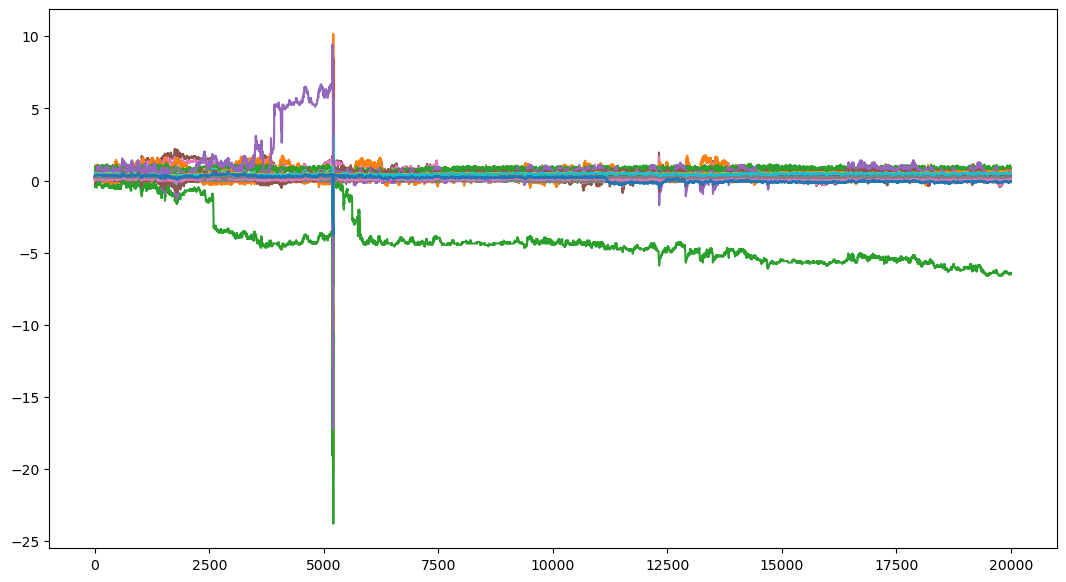

In [24]:
plt.figure(figsize=(13,7))
plt.plot(df_sample_test_scaled)
plt.show()

In [25]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)

In [26]:
model = keras.models.load_model("../logs/train/2/best_model.h5")
model.summary()

Model: "LSTM-Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            24576     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            24832     
                                                  

In [27]:
pred = model.predict(df_sample_test_scaled_3d)

625/625 [==============================] - 5s 7ms/step


In [28]:
pred_2d_inv = inverse_convert_time_window(pred)
r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)

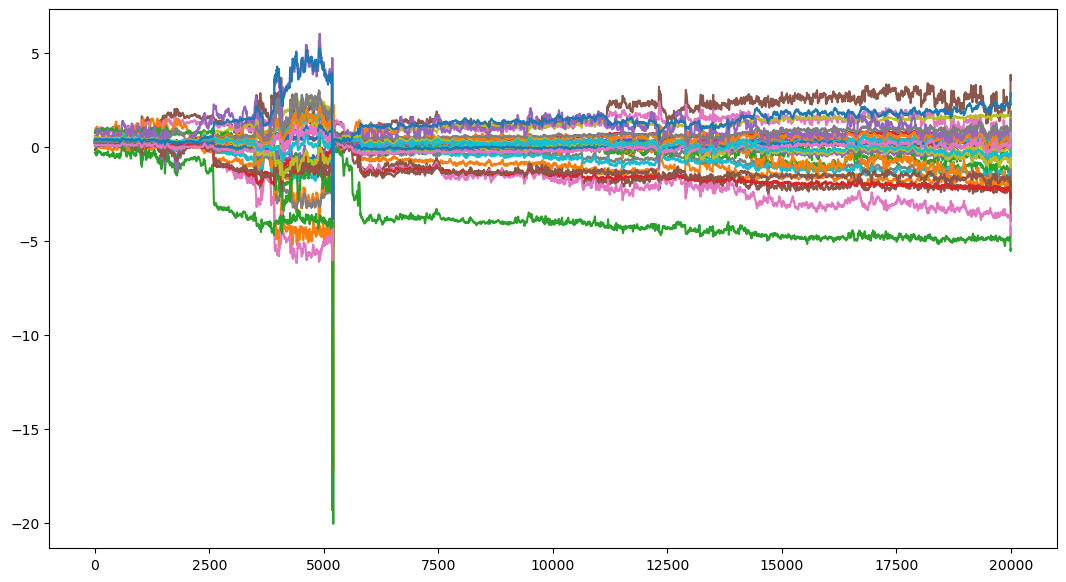

In [29]:
plt.figure(figsize=(13,7))
plt.plot(pred_2d_inv)
plt.show()

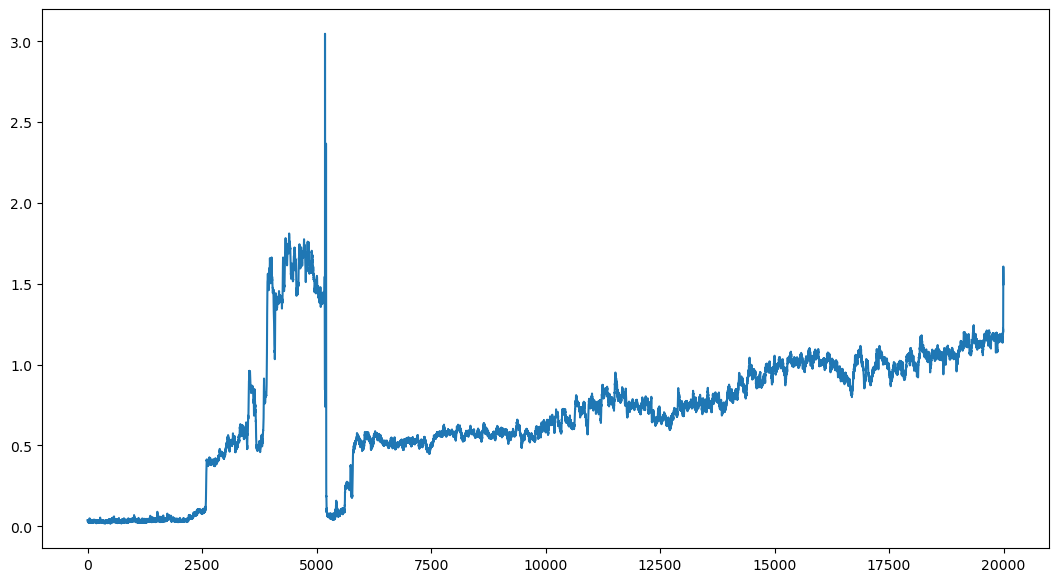

In [30]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.show()